In [1]:
# Requirements
# Comment if already satisfied
#!pip install -U jupyter
#!pip install datasets transformers accelerate torch torchinfo xlrd seaborn sklearn torchmetrics
#!pip install --upgrade --quiet jupyter_client ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

This model is the same as the one in `train_classification_model` but the training data no longer has conflicted ADUs.

In [2]:
import os
import pandas as pd

DATA_DIR = "../data/"
LM_DIR = "./out/language_model"
OUT_DIR = "./out/classification_model2"

os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42

In [3]:
import matplotlib.pyplot as plt
def plot_training_history(train_history, val_history, model_name, phase_name, out_dir):
    fig, (loss_ax, acc_ax) = plt.subplots(figsize=(12, 8), nrows=2)
    fig.suptitle(f"{model_name} - {phase_name} History")
    loss_ax.set_title("Cross Entropy Loss")
    loss_ax.plot(train_history["loss"], label="train")
    loss_ax.plot(val_history["loss"], label="val")
    loss_ax.legend(loc="best")

    acc_ax.set_title("Classification accuracy")
    acc_ax.plot(train_history["accuracy"], label="train")
    acc_ax.plot(val_history["accuracy"], label="val")
    loss_ax.legend(loc="best")

    plt.tight_layout()

    fig.savefig(f"{out_dir}/{model_name}_{phase_name}_history.png", dpi=150, bbox_inches='tight')

    return fig

# Load Dataset

In [4]:
#articles = pd.read_excel(os.path.join(DATA_DIR, "OpArticles_ADUs.xlsx"))
adus = pd.read_csv(os.path.join(DATA_DIR, "OpArticles_ADUs.csv")) # If pandas version doesn't support .xlsx, use this instaed
adus = adus.reset_index()

adus.head()

,index,article_id,annotator,node,ranges,tokens,label
0,0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,Value
1,1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,Value
2,2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,Value
3,3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,Value
4,4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value


# Check for conflicts on annotations

In [5]:
unique_adus = adus.drop_duplicates(subset=["article_id", "tokens"], keep=False)

print(f"Original dataset shape: {adus.shape} | Unique dataset shape: {unique_adus.shape}")
unique_adus.head()

Original dataset shape: (16743, 7) | Unique dataset shape: (8342, 7)


,index,article_id,annotator,node,ranges,tokens,label
4,4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value
5,5,5d04a31b896a7fea069ef06f,A,7,"[[4305, 4404]]",alguém os convenceu de que devem ter como crit...,Value
8,8,5d04a31b896a7fea069ef06f,A,11,"[[3778, 3922]]",toda a comunidade jornalística continua a trat...,Value
9,9,5d04a31b896a7fea069ef06f,B,0,"[[1321, 1387]]",“o Portugal que morre” morre anónimo e esqueci...,Value(-)
10,10,5d04a31b896a7fea069ef06f,B,1,"[[1153, 1316]]",Há no discurso político uma tal preocupação co...,Value(-)


In [6]:
duplicated_adus = adus.loc[adus.index.difference(unique_adus.index)].sort_values(by=["article_id", "tokens"])

duplicated_adus

,index,article_id,annotator,node,ranges,tokens,label
15230,15230,5cdd971b896a7fea062d6e3d,A,23,"[[4683, 4740]]",Esta defesa do indefensável é particularmente ...,Value(-)
15248,15248,5cdd971b896a7fea062d6e3d,B,23,"[[4683, 4740]]",Esta defesa do indefensável é particularmente ...,Value(-)
15260,15260,5cdd971b896a7fea062d6e3d,C,12,"[[4683, 4740]]",Esta defesa do indefensável é particularmente ...,Value(-)
15220,15220,5cdd971b896a7fea062d6e3d,A,5,"[[2467, 2521]]",Já de si isto seria problemático em termos ped...,Value
15239,15239,5cdd971b896a7fea062d6e3d,B,9,"[[2467, 2521]]",Já de si isto seria problemático em termos ped...,Value(-)
...,...,...,...,...,...,...,...
1957,1957,5d04c671896a7fea06a11275,D,12,"[[1433, 1467]]",Uma coisa é o futebol outra é Deus,Fact
1937,1937,5d04c671896a7fea06a11275,B,2,"[[942, 1097]]",abster-se de participar em órgãos sociais do s...,Value
1955,1955,5d04c671896a7fea06a11275,D,9,"[[942, 1097]]",abster-se de participar em órgãos sociais do s...,Policy
1943,1943,5d04c671896a7fea06a11275,C,0,"[[1376, 1431]]",É completamente descabido misturar religião co...,Value(-)


Label Ratios
Value       0.474227
Fact        0.233158
Value(-)    0.171422
Value(+)    0.083793
Policy      0.037401
Name: label, dtype: float64


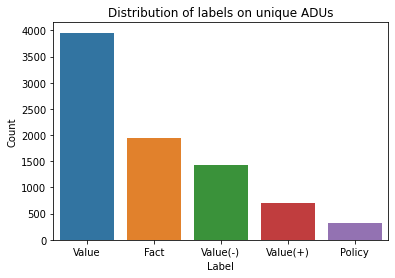

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Label Ratios")
print(unique_adus["label"].value_counts() / len(unique_adus["label"]))

fig, ax = plt.subplots()
sns.countplot(data=unique_adus, x="label", ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"])
ax.set_title("Distribution of labels on unique ADUs")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/unique_label_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

Label Ratios
Value       0.493513
Fact        0.204499
Value(-)    0.174979
Value(+)    0.084752
Policy      0.042257
Name: label, dtype: float64


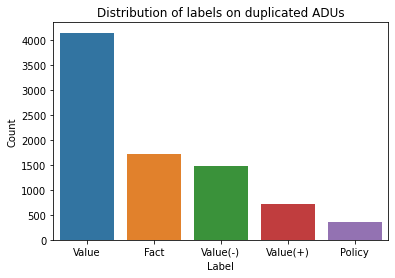

<Figure size 432x288 with 0 Axes>

In [8]:
print("Label Ratios")
print(duplicated_adus["label"].value_counts() / len(duplicated_adus["label"]))

fig, ax = plt.subplots()
sns.countplot(data=duplicated_adus, x="label", ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"])
ax.set_title("Distribution of labels on duplicated ADUs")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/duplicated_label_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

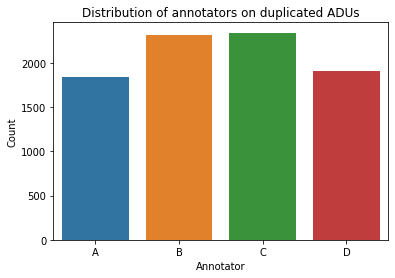

<Figure size 432x288 with 0 Axes>

In [9]:
fig, ax = plt.subplots()
sns.countplot(data=duplicated_adus, x="annotator", ax=ax, order=["A", "B", "C", "D"])
ax.set_title("Distribution of annotators on duplicated ADUs")
ax.set_xlabel("Annotator")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/duplicated_annotators_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

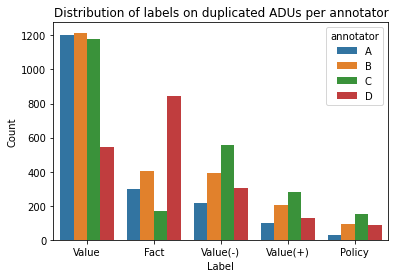

<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax = plt.subplots()
sns.countplot(data=duplicated_adus, x="label", hue="annotator", ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"], hue_order=["A", "B", "C", "D"])
ax.set_title("Distribution of labels on duplicated ADUs per annotator")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/duplicated_label_distribution_per_annotator.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

# Filter by majority (mode)

In [11]:
modes = duplicated_adus.groupby(by=["article_id", "tokens"])["label"].apply(pd.Series.mode).reset_index(level=2, drop=True).reset_index()
modes

,article_id,tokens,label
0,5cdd971b896a7fea062d6e3d,Esta defesa do indefensável é particularmente ...,Value(-)
1,5cdd971b896a7fea062d6e3d,Já de si isto seria problemático em termos ped...,Value
2,5cdd971b896a7fea062d6e3d,Já de si isto seria problemático em termos ped...,Value(-)
3,5cdd971b896a7fea062d6e3d,a PE parece presumir que em relação a esse per...,Value
4,5cdd971b896a7fea062d6e3d,a ocasião propicia um debate amplo na sociedad...,Value
...,...,...,...
4908,5d04c671896a7fea06a11275,Uma coisa é o futebol outra é Deus,Fact
4909,5d04c671896a7fea06a11275,Uma coisa é o futebol outra é Deus,Value
4910,5d04c671896a7fea06a11275,abster-se de participar em órgãos sociais do s...,Policy
4911,5d04c671896a7fea06a11275,abster-se de participar em órgãos sociais do s...,Value


Check for ADUs with more than one mode

In [12]:
modes[(modes.groupby(by=["article_id", "tokens"]).transform("count") > 1)["label"]]

,article_id,tokens,label
1,5cdd971b896a7fea062d6e3d,Já de si isto seria problemático em termos ped...,Value
2,5cdd971b896a7fea062d6e3d,Já de si isto seria problemático em termos ped...,Value(-)
4,5cdd971b896a7fea062d6e3d,a ocasião propicia um debate amplo na sociedad...,Value
5,5cdd971b896a7fea062d6e3d,a ocasião propicia um debate amplo na sociedad...,Value(+)
11,5cdd971b896a7fea062d6e3d,os autores do livro naturalizam a escravização...,Value
...,...,...,...
4895,5d04c590896a7fea06a0fc78,Carismático,Value(+)
4908,5d04c671896a7fea06a11275,Uma coisa é o futebol outra é Deus,Fact
4909,5d04c671896a7fea06a11275,Uma coisa é o futebol outra é Deus,Value
4910,5d04c671896a7fea06a11275,abster-se de participar em órgãos sociais do s...,Policy


ADUs with one mode only

In [13]:
adus_majority = modes[(modes.groupby(by=["article_id", "tokens"]).transform("count") == 1)["label"]]
adus_majority

,article_id,tokens,label
0,5cdd971b896a7fea062d6e3d,Esta defesa do indefensável é particularmente ...,Value(-)
3,5cdd971b896a7fea062d6e3d,a PE parece presumir que em relação a esse per...,Value
6,5cdd971b896a7fea062d6e3d,basta consultarmos uma fonte incontornável par...,Value
7,5cdd971b896a7fea062d6e3d,ensinar a mentira histórica não é compatível c...,Value
8,5cdd971b896a7fea062d6e3d,esta questão ter [justificadamente] despertado...,Value
...,...,...,...
4904,5d04c590896a7fea06a0fc78,motivador nato,Value(+)
4905,5d04c590896a7fea06a0fc78,verdadeiro,Value(+)
4906,5d04c671896a7fea06a11275,Um presidente de câmara pode pertencer à admin...,Value
4907,5d04c671896a7fea06a11275,Um presidente de câmara pode ter a sua preferê...,Value


Label Ratios
Value       0.534856
Value(-)    0.177083
Fact        0.166667
Value(+)    0.075721
Policy      0.045673
Name: label, dtype: float64


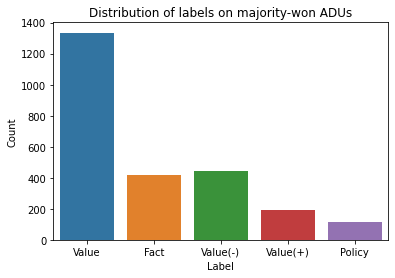

<Figure size 432x288 with 0 Axes>

In [14]:
print("Label Ratios")
print(adus_majority["label"].value_counts() / len(adus_majority["label"]))

fig, ax = plt.subplots()
sns.countplot(data=adus_majority, x="label", ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"])
ax.set_title("Distribution of labels on majority-won ADUs")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/adus_majority_label_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

Merge into a single dataset containing only unique ADUs and the ADUs that won by majority

In [15]:
def get_index(row):
    articleId = row["article_id"]
    tokens = row["tokens"]
    label = row["label"]
    
    index = adus[(adus["article_id"] == articleId) & (adus["tokens"] == tokens) & (adus["label"] == label)].iloc[0]["index"]

    return [index, articleId, tokens, label]
    

adus_majority = adus_majority.apply(get_index, axis=1, result_type="expand").rename(columns={0:"index", 1:"article_id", 2:"tokens", 3:"label"})

In [16]:
final_adus = pd.concat([unique_adus[["index", "article_id", "tokens", "label"]], adus_majority])

final_adus

,index,article_id,tokens,label
4,4,5d04a31b896a7fea069ef06f,não nos fazem rir à custa dos poderosos,Value
5,5,5d04a31b896a7fea069ef06f,alguém os convenceu de que devem ter como crit...,Value
8,8,5d04a31b896a7fea069ef06f,toda a comunidade jornalística continua a trat...,Value
9,9,5d04a31b896a7fea069ef06f,“o Portugal que morre” morre anónimo e esqueci...,Value(-)
10,10,5d04a31b896a7fea069ef06f,Há no discurso político uma tal preocupação co...,Value(-)
...,...,...,...,...
4904,1915,5d04c590896a7fea06a0fc78,motivador nato,Value(+)
4905,1913,5d04c590896a7fea06a0fc78,verdadeiro,Value(+)
4906,1935,5d04c671896a7fea06a11275,Um presidente de câmara pode pertencer à admin...,Value
4907,1938,5d04c671896a7fea06a11275,Um presidente de câmara pode ter a sua preferê...,Value


Label Ratios
Value       0.488190
Fact        0.217845
Value(-)    0.172726
Value(+)    0.081934
Policy      0.039306
Name: label, dtype: float64


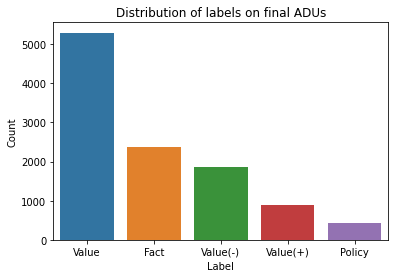

<Figure size 432x288 with 0 Axes>

In [17]:
print("Label Ratios")
print(final_adus["label"].value_counts() / len(final_adus["label"]))

fig, ax = plt.subplots()
sns.countplot(data=final_adus, x="label", ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"])
ax.set_title("Distribution of labels on final ADUs")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/final_label_distribution_full.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

Encode Labels

In [18]:
classes = ["Fact", "Policy", "Value", "Value(+)", "Value(-)"]
N_CLASSES = len(classes)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_adus["label"] = le.fit_transform(final_adus["label"])

final_adus

,index,article_id,tokens,label
4,4,5d04a31b896a7fea069ef06f,não nos fazem rir à custa dos poderosos,2
5,5,5d04a31b896a7fea069ef06f,alguém os convenceu de que devem ter como crit...,2
8,8,5d04a31b896a7fea069ef06f,toda a comunidade jornalística continua a trat...,2
9,9,5d04a31b896a7fea069ef06f,“o Portugal que morre” morre anónimo e esqueci...,4
10,10,5d04a31b896a7fea069ef06f,Há no discurso político uma tal preocupação co...,4
...,...,...,...,...
4904,1915,5d04c590896a7fea06a0fc78,motivador nato,3
4905,1913,5d04c590896a7fea06a0fc78,verdadeiro,3
4906,1935,5d04c671896a7fea06a11275,Um presidente de câmara pode pertencer à admin...,2
4907,1938,5d04c671896a7fea06a11275,Um presidente de câmara pode ter a sua preferê...,2


# Create Train, Validation and Test splits

Train Label Ratios
Value       0.488178
Fact        0.217849
Value(-)    0.172722
Value(+)    0.081892
Policy      0.039360
dtype: float64
Validation Label Ratios
Value       0.492172
Fact        0.216474
Value(-)    0.173587
Value(+)    0.080327
Policy      0.037440
dtype: float64
Test Label Ratios
Value       0.491886
Fact        0.219922
Value(-)    0.169558
Value(+)    0.080022
Policy      0.038612
dtype: float64


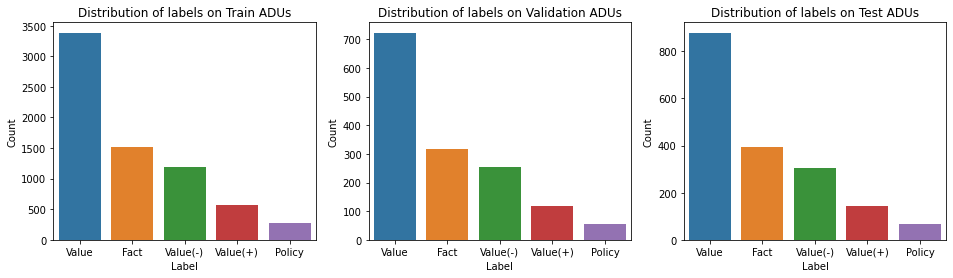

<Figure size 432x288 with 0 Axes>

In [19]:
# Maintain the ratios of labels across splits
train_val_adus = final_adus.groupby("label").sample(frac=0.8, random_state=SEED)
test_adus = final_adus.loc[final_adus.index.difference(train_val_adus.index)]

train_adus = train_val_adus.groupby("label").sample(frac=0.8, random_state=SEED)
val_adus = train_val_adus.loc[train_val_adus.index.difference(train_adus.index)]

fig, (train_ax, val_ax, test_ax) = plt.subplots(figsize=(16, 4), ncols=3)
for split, df, ax in zip(["Train", "Validation", "Test"], [train_adus, val_adus, test_adus], [train_ax, val_ax, test_ax]):
    df_labels = le.inverse_transform(df["label"])
    sns.countplot(x=df_labels, ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"])
    ax.set_title(f"Distribution of labels on {split} ADUs")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    
    print(f"{split} Label Ratios")
    print(pd.Series(df_labels).value_counts() / len(df_labels))
fig.savefig(f"{OUT_DIR}/label_distribution_splits.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

In [20]:
train_adus

,index,article_id,tokens,label
5684,5684,5cf46b97896a7fea0600233c,"A Lei, contudo, é cega e igual para todos",0
4566,791,5d04be5c896a7fea06a07cba,"não se pode legislar por resoluções, sejam do ...",0
6708,6708,5cf4665e896a7fea06ffd932,"em 2012, havia “despesa efectiva” e “despesa e...",0
827,14156,5cf45c2c896a7fea06ff3e2a,O índice de envelhecimento e de dependência de...,0
8436,8436,5cf463d6896a7fea06ffb4a8,na verdade não ser inteiramente de raiz,0
...,...,...,...,...
7533,7533,5cf4650f896a7fea06ffbe46,"Dez anos depois da crise, o mercado de trabalh...",4
1436,11673,5cf45f5e896a7fea06ff68c2,ser uma leviandade reputarem-se estes gastos d...,4
813,813,5d04be5c896a7fea06a07cba,"é, a meu ver, um aborto ortográfico",4
14472,14472,5cf45b77896a7fea06ff28ff,"derrapando, aos empurrões, para um proteccioni...",4


# Convert Dataset to HF Dataset

In [21]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, DatasetInfo, Features, Value, ClassLabel
info = DatasetInfo(
    features=Features({
        "index": Value("int64"),
        "tokens": Value("string"),
        "label": ClassLabel(num_classes=N_CLASSES, names=le.classes_.tolist()),
        "article_id": Value("string"),
    })
)

adus_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_adus, preserve_index=False, info=info),
    "val": Dataset.from_pandas(val_adus, preserve_index=False, info=info),
    "test": Dataset.from_pandas(test_adus, preserve_index=False, info=info)
})

print(adus_dataset)

DatasetDict({
    train: Dataset({
        features: ['index', 'tokens', 'label', 'article_id'],
        num_rows: 6936
    })
    val: Dataset({
        features: ['index', 'tokens', 'label', 'article_id'],
        num_rows: 1469
    })
    test: Dataset({
        features: ['index', 'tokens', 'label', 'article_id'],
        num_rows: 1787
    })
})


In [22]:
adus_dataset["train"].features

{'index': Value(dtype='int64', id=None),
 'tokens': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=5, names=['Fact', 'Policy', 'Value', 'Value(+)', 'Value(-)'], id=None),
 'article_id': Value(dtype='string', id=None)}

Base Tokenizer

In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=True)

In [24]:
def tokenize(batch):
    result = tokenizer(batch["tokens"])
    return result

In [25]:
cls_dataset = adus_dataset.map(
    tokenize, batched=True, remove_columns=["article_id", "tokens"]
)

print(cls_dataset)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['index', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6936
    })
    val: Dataset({
        features: ['index', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1469
    })
    test: Dataset({
        features: ['index', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1787
    })
})


# Define Dataloaders

In [26]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

BATCH_SIZE = 64 # Tested with NVIDIA Tesla T4 16GB
train_dataloader = DataLoader(
    dataset=cls_dataset["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    dataset=cls_dataset["val"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    dataset=cls_dataset["test"],
    shuffle=False,
    batch_size=1,
    collate_fn=data_collator
)

# Model Definition

In [27]:
from transformers import AutoModelForSequenceClassification
from torchinfo import summary

model = AutoModelForSequenceClassification.from_pretrained(f"{LM_DIR}/best", num_labels=N_CLASSES)

summary(model)

Some weights of the model checkpoint at ./out/language_model/best were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./out/language_mode

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              30,509,056
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,125
Total params:

# Define Optimizer

In [28]:
from torch import optim

optimizer = optim.Adam(
    params=model.parameters(),
    lr=5e-3,
    betas=(0.9, 0.999),
    weight_decay=1e-4,
    amsgrad=True
)

# Prepare Classification Model

In [29]:
from accelerate import Accelerator

accelerator = Accelerator()

model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


# Define Epoch Iteration

In [30]:
import json
synonyms = {}

with open(DATA_DIR + "/synonyms.json", "r", encoding="utf-8") as synonyms_json:
    synonyms = json.load(synonyms_json)

synonyms_tokenized = {}
n = 0
for k, v in synonyms.items():
    tokens_k = tokenizer.encode(k, add_special_tokens=False)

    # Don't allow multi token for simplicity
    if len(tokens_k) > 1:
        continue

    token_v = [tokenizer.encode(s, add_special_tokens=False) for s in v]
    token_v = [tv[0] for tv in token_v if len(tv) == 1]

    if token_v:
        synonyms_tokenized[tokens_k[0]] = token_v

    
def add_synonyms(input_ids, p = 0.05):
    for i in range(len(input_ids)):
        inputId = input_ids[i].item()
        if (inputId in synonyms_tokenized) and np.random.binomial(1, p):
            input_ids[i] = np.random.choice(synonyms_tokenized[inputId])

In [31]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

def epoch_iter(dataloader, model, is_train = True, optimizer=None, lr_scheduler=None):
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    probs = []
    preds = []
    expected_labels = []
    aduIds = []
    
    scaler = torch.cuda.amp.GradScaler()

    with torch.set_grad_enabled(is_train):
        for batch in tqdm(dataloader):
            index = batch.pop("index")

            if is_train:
                for b_input_ids in batch["input_ids"]:
                    add_synonyms(b_input_ids, p=0.3)
            
            with torch.cuda.amp.autocast():
                outputs = model(**batch)
            loss = outputs.loss

            if is_train:
                optimizer.zero_grad()
                accelerator.backward(scaler.scale(loss))
                scaler.step(optimizer)
                scaler.update()
            
            total_loss += loss.item()

            prob = F.softmax(outputs.logits, dim=1)
            final_pred = torch.argmax(prob, dim=1)

            aduIds.extend(index.detach().cpu().numpy())
            probs.extend(prob.detach().cpu().numpy())
            preds.extend(final_pred.detach().cpu().numpy())
            expected_labels.extend(batch["labels"].detach().cpu().numpy())
            
        if is_train and lr_scheduler is not None:
            lr_scheduler.step()
        
    return (expected_labels, preds, probs, aduIds), total_loss / num_batches


# Train Classification Model

In [32]:
from torch import optim
import torchmetrics

NUM_EPOCHS = 30

lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer,
    gamma=0.9,
    verbose=True
)

metric_scorer = torchmetrics.Accuracy(
    threshold=0.5,
    num_classes=N_CLASSES,
    average="micro",
)

Adjusting learning rate of group 0 to 5.0000e-03.


In [33]:
train_history = {
    "loss": [],
    "accuracy": []
}

val_history = {
    "loss": [],
    "accuracy": []
}

model.bert.requires_grad_(False) # Freeze language model layer

best_loss = np.inf
best_accuracy = 0
best_epoch = -1

print(f"Starting classification language model training...")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{NUM_EPOCHS}]")
    
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        is_train=True,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler
    )
    
    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")
    
    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        best_accuracy = val_accuracy
        best_epoch = epoch
        
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(f"{OUT_DIR}/best", save_function=accelerator.save)

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(f"{OUT_DIR}/latest", save_function=accelerator.save)

    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_accuracy)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")
    
print(
    f"\nFinished training..."
    f"\nBest epoch: {best_epoch}\t Validation loss on best epoch: {best_loss}\t Accuracy on best epoch: {best_accuracy}"
)

Starting classification language model training...
Epoch[1/30]


100%|██████████| 109/109 [00:34<00:00,  3.12it/s]


Adjusting learning rate of group 0 to 4.5000e-03.
Training loss: 1.241	 Training micro accuracy: 0.504


100%|██████████| 23/23 [00:05<00:00,  3.89it/s]


Validation loss: 1.136	 Validation micro accuracy: 0.530
----------------------------------------------------------------
Epoch[2/30]


100%|██████████| 109/109 [00:35<00:00,  3.11it/s]


Adjusting learning rate of group 0 to 4.0500e-03.
Training loss: 1.126	 Training micro accuracy: 0.543


100%|██████████| 23/23 [00:05<00:00,  3.85it/s]


Validation loss: 1.097	 Validation micro accuracy: 0.534
----------------------------------------------------------------
Epoch[3/30]


100%|██████████| 109/109 [00:35<00:00,  3.05it/s]


Adjusting learning rate of group 0 to 3.6450e-03.
Training loss: 1.110	 Training micro accuracy: 0.553


100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


Validation loss: 1.078	 Validation micro accuracy: 0.549
----------------------------------------------------------------
Epoch[4/30]


100%|██████████| 109/109 [00:35<00:00,  3.05it/s]


Adjusting learning rate of group 0 to 3.2805e-03.
Training loss: 1.094	 Training micro accuracy: 0.560


100%|██████████| 23/23 [00:06<00:00,  3.78it/s]


Validation loss: 1.067	 Validation micro accuracy: 0.555
----------------------------------------------------------------
Epoch[5/30]


100%|██████████| 109/109 [00:35<00:00,  3.09it/s]


Adjusting learning rate of group 0 to 2.9525e-03.
Training loss: 1.083	 Training micro accuracy: 0.566


100%|██████████| 23/23 [00:05<00:00,  3.84it/s]


Validation loss: 1.049	 Validation micro accuracy: 0.560
----------------------------------------------------------------
Epoch[6/30]


100%|██████████| 109/109 [00:35<00:00,  3.06it/s]


Adjusting learning rate of group 0 to 2.6572e-03.
Training loss: 1.086	 Training micro accuracy: 0.558


100%|██████████| 23/23 [00:05<00:00,  3.85it/s]


Validation loss: 1.062	 Validation micro accuracy: 0.555
----------------------------------------------------------------
Epoch[7/30]


100%|██████████| 109/109 [00:34<00:00,  3.12it/s]


Adjusting learning rate of group 0 to 2.3915e-03.
Training loss: 1.072	 Training micro accuracy: 0.565


100%|██████████| 23/23 [00:06<00:00,  3.82it/s]


Validation loss: 1.045	 Validation micro accuracy: 0.559
----------------------------------------------------------------
Epoch[8/30]


100%|██████████| 109/109 [00:35<00:00,  3.03it/s]


Adjusting learning rate of group 0 to 2.1523e-03.
Training loss: 1.060	 Training micro accuracy: 0.574


100%|██████████| 23/23 [00:06<00:00,  3.78it/s]


Validation loss: 1.058	 Validation micro accuracy: 0.569
----------------------------------------------------------------
Epoch[9/30]


100%|██████████| 109/109 [00:35<00:00,  3.06it/s]


Adjusting learning rate of group 0 to 1.9371e-03.
Training loss: 1.053	 Training micro accuracy: 0.572


100%|██████████| 23/23 [00:06<00:00,  3.75it/s]


Validation loss: 1.028	 Validation micro accuracy: 0.571
----------------------------------------------------------------
Epoch[10/30]


100%|██████████| 109/109 [00:36<00:00,  3.00it/s]


Adjusting learning rate of group 0 to 1.7434e-03.
Training loss: 1.047	 Training micro accuracy: 0.577


100%|██████████| 23/23 [00:06<00:00,  3.62it/s]


Validation loss: 1.029	 Validation micro accuracy: 0.570
----------------------------------------------------------------
Epoch[11/30]


100%|██████████| 109/109 [00:37<00:00,  2.94it/s]


Adjusting learning rate of group 0 to 1.5691e-03.
Training loss: 1.047	 Training micro accuracy: 0.574


100%|██████████| 23/23 [00:06<00:00,  3.54it/s]


Validation loss: 1.028	 Validation micro accuracy: 0.564
----------------------------------------------------------------
Epoch[12/30]


100%|██████████| 109/109 [00:37<00:00,  2.92it/s]


Adjusting learning rate of group 0 to 1.4121e-03.
Training loss: 1.039	 Training micro accuracy: 0.584


100%|██████████| 23/23 [00:06<00:00,  3.52it/s]


Validation loss: 1.029	 Validation micro accuracy: 0.566
----------------------------------------------------------------
Epoch[13/30]


100%|██████████| 109/109 [00:37<00:00,  2.87it/s]


Adjusting learning rate of group 0 to 1.2709e-03.
Training loss: 1.043	 Training micro accuracy: 0.571


100%|██████████| 23/23 [00:06<00:00,  3.45it/s]


Validation loss: 1.031	 Validation micro accuracy: 0.562
----------------------------------------------------------------
Epoch[14/30]


100%|██████████| 109/109 [00:37<00:00,  2.91it/s]


Adjusting learning rate of group 0 to 1.1438e-03.
Training loss: 1.045	 Training micro accuracy: 0.573


100%|██████████| 23/23 [00:06<00:00,  3.63it/s]


Validation loss: 1.018	 Validation micro accuracy: 0.568
----------------------------------------------------------------
Epoch[15/30]


100%|██████████| 109/109 [00:35<00:00,  3.04it/s]


Adjusting learning rate of group 0 to 1.0295e-03.
Training loss: 1.031	 Training micro accuracy: 0.579


100%|██████████| 23/23 [00:06<00:00,  3.82it/s]


Validation loss: 1.028	 Validation micro accuracy: 0.557
----------------------------------------------------------------
Epoch[16/30]


100%|██████████| 109/109 [00:35<00:00,  3.05it/s]


Adjusting learning rate of group 0 to 9.2651e-04.
Training loss: 1.032	 Training micro accuracy: 0.581


100%|██████████| 23/23 [00:06<00:00,  3.83it/s]


Validation loss: 1.021	 Validation micro accuracy: 0.568
----------------------------------------------------------------
Epoch[17/30]


100%|██████████| 109/109 [00:35<00:00,  3.05it/s]


Adjusting learning rate of group 0 to 8.3386e-04.
Training loss: 1.024	 Training micro accuracy: 0.579


100%|██████████| 23/23 [00:06<00:00,  3.81it/s]


Validation loss: 1.016	 Validation micro accuracy: 0.570
----------------------------------------------------------------
Epoch[18/30]


100%|██████████| 109/109 [00:35<00:00,  3.08it/s]


Adjusting learning rate of group 0 to 7.5047e-04.
Training loss: 1.014	 Training micro accuracy: 0.584


100%|██████████| 23/23 [00:06<00:00,  3.77it/s]


Validation loss: 1.016	 Validation micro accuracy: 0.568
----------------------------------------------------------------
Epoch[19/30]


100%|██████████| 109/109 [00:36<00:00,  3.03it/s]


Adjusting learning rate of group 0 to 6.7543e-04.
Training loss: 1.019	 Training micro accuracy: 0.587


100%|██████████| 23/23 [00:06<00:00,  3.74it/s]


Validation loss: 1.019	 Validation micro accuracy: 0.566
----------------------------------------------------------------
Epoch[20/30]


100%|██████████| 109/109 [00:35<00:00,  3.05it/s]


Adjusting learning rate of group 0 to 6.0788e-04.
Training loss: 1.016	 Training micro accuracy: 0.592


100%|██████████| 23/23 [00:06<00:00,  3.62it/s]


Validation loss: 1.013	 Validation micro accuracy: 0.568
----------------------------------------------------------------
Epoch[21/30]


100%|██████████| 109/109 [00:37<00:00,  2.93it/s]


Adjusting learning rate of group 0 to 5.4709e-04.
Training loss: 1.023	 Training micro accuracy: 0.591


100%|██████████| 23/23 [00:06<00:00,  3.53it/s]


Validation loss: 1.027	 Validation micro accuracy: 0.568
----------------------------------------------------------------
Epoch[22/30]


100%|██████████| 109/109 [00:37<00:00,  2.89it/s]


Adjusting learning rate of group 0 to 4.9239e-04.
Training loss: 1.019	 Training micro accuracy: 0.591


100%|██████████| 23/23 [00:06<00:00,  3.52it/s]


Validation loss: 1.018	 Validation micro accuracy: 0.572
----------------------------------------------------------------
Epoch[23/30]


100%|██████████| 109/109 [00:38<00:00,  2.87it/s]


Adjusting learning rate of group 0 to 4.4315e-04.
Training loss: 1.016	 Training micro accuracy: 0.587


100%|██████████| 23/23 [00:06<00:00,  3.47it/s]


Validation loss: 1.014	 Validation micro accuracy: 0.571
----------------------------------------------------------------
Epoch[24/30]


100%|██████████| 109/109 [00:37<00:00,  2.89it/s]


Adjusting learning rate of group 0 to 3.9883e-04.
Training loss: 1.018	 Training micro accuracy: 0.583


100%|██████████| 23/23 [00:06<00:00,  3.42it/s]


Validation loss: 1.015	 Validation micro accuracy: 0.574
----------------------------------------------------------------
Epoch[25/30]


100%|██████████| 109/109 [00:37<00:00,  2.89it/s]


Adjusting learning rate of group 0 to 3.5895e-04.
Training loss: 1.021	 Training micro accuracy: 0.581


100%|██████████| 23/23 [00:06<00:00,  3.43it/s]


Validation loss: 1.011	 Validation micro accuracy: 0.577
----------------------------------------------------------------
Epoch[26/30]


100%|██████████| 109/109 [00:37<00:00,  2.91it/s]


Adjusting learning rate of group 0 to 3.2305e-04.
Training loss: 1.001	 Training micro accuracy: 0.595


100%|██████████| 23/23 [00:06<00:00,  3.45it/s]


Validation loss: 1.014	 Validation micro accuracy: 0.570
----------------------------------------------------------------
Epoch[27/30]


100%|██████████| 109/109 [00:37<00:00,  2.93it/s]


Adjusting learning rate of group 0 to 2.9075e-04.
Training loss: 1.013	 Training micro accuracy: 0.591


100%|██████████| 23/23 [00:06<00:00,  3.44it/s]


Validation loss: 1.020	 Validation micro accuracy: 0.567
----------------------------------------------------------------
Epoch[28/30]


100%|██████████| 109/109 [00:38<00:00,  2.85it/s]


Adjusting learning rate of group 0 to 2.6167e-04.
Training loss: 1.015	 Training micro accuracy: 0.590


100%|██████████| 23/23 [00:06<00:00,  3.43it/s]


Validation loss: 1.011	 Validation micro accuracy: 0.568
----------------------------------------------------------------
Epoch[29/30]


100%|██████████| 109/109 [00:37<00:00,  2.88it/s]


Adjusting learning rate of group 0 to 2.3551e-04.
Training loss: 1.025	 Training micro accuracy: 0.581


100%|██████████| 23/23 [00:06<00:00,  3.43it/s]


Validation loss: 1.014	 Validation micro accuracy: 0.566
----------------------------------------------------------------
Epoch[30/30]


100%|██████████| 109/109 [00:37<00:00,  2.91it/s]


Adjusting learning rate of group 0 to 2.1196e-04.
Training loss: 1.018	 Training micro accuracy: 0.591


100%|██████████| 23/23 [00:06<00:00,  3.43it/s]


Validation loss: 1.012	 Validation micro accuracy: 0.575
----------------------------------------------------------------

Finished training...
Best epoch: 25	 Validation loss on best epoch: 1.010990655940512	 Accuracy on best epoch: 0.5772634148597717


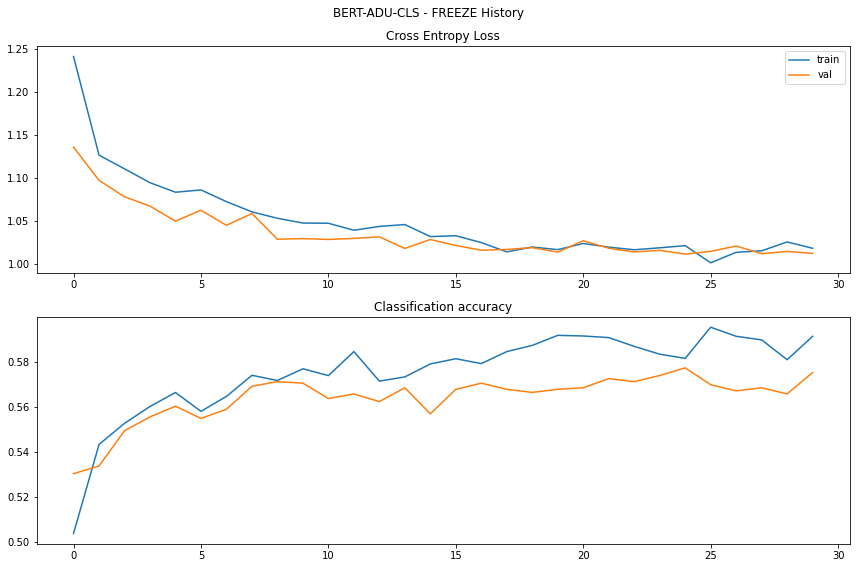

In [34]:
fig = plot_training_history(train_history=train_history, val_history=val_history, model_name="BERT-ADU-CLS", phase_name="FREEZE", out_dir=OUT_DIR)
fig.show()

Clear GPU memory for guarantees

In [35]:
import gc
model = None
train_dataloader = None
val_dataloader = None
lr_scheduler = None
optimizer = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info("cuda:0")

(13303742464, 15843721216)

In [36]:
!nvidia-smi

Wed Jun  8 05:42:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |   2422MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Fine-tune model
Load best model from first training session

In [37]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

BATCH_SIZE = 16 # Tested with NVIDIA Tesla T4 16GB

train_dataloader = DataLoader(
    dataset=cls_dataset["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    dataset=cls_dataset["val"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

In [38]:
model = AutoModelForSequenceClassification.from_pretrained(f"{OUT_DIR}/best", num_labels=N_CLASSES)

print("Loaded best model...")

summary(model)

Loaded best model...


Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              30,509,056
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,125
Total params:

In [39]:
ft_optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-5,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

accelerator = Accelerator()

model, ft_optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, ft_optimizer, train_dataloader, val_dataloader
)

ft_lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=ft_optimizer,
    gamma=0.9,
    verbose=True
)

Adjusting learning rate of group 0 to 1.0000e-05.


In [40]:
ft_train_history = {
    "loss": [],
    "accuracy": []
}

ft_val_history = {
    "loss": [],
    "accuracy": []
}

FT_NUM_EPOCHS = 15
model.bert.requires_grad_(True) # Unfreeze language model layer

ft_best_loss = best_loss 
ft_best_accuracy = best_accuracy
ft_best_epoch = -1

print(f"Starting classification language model fine-tuning...")

for epoch in range(1, FT_NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{FT_NUM_EPOCHS}]")
    
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        is_train=True,
        optimizer=ft_optimizer,
        lr_scheduler=ft_lr_scheduler
    )
    
    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")
    
    # Save best model
    if val_loss < ft_best_loss:
        ft_best_loss = val_loss
        ft_best_accuracy = val_accuracy
        ft_best_epoch = epoch
        
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(f"{OUT_DIR}/fine_tuned/best", save_function=accelerator.save)

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(f"{OUT_DIR}/fine_tuned/latest", save_function=accelerator.save)

    ft_train_history["loss"].append(train_loss)
    ft_train_history["accuracy"].append(train_accuracy)

    ft_val_history["loss"].append(val_loss)
    ft_val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")
    
print(
    f"\nFinished fine-tuning..."
    f"\nBest epoch: {ft_best_epoch}\t Validation loss on best epoch: {ft_best_loss}\t Accuracy on best epoch: {ft_best_accuracy}"
)

Starting classification language model fine-tuning...
Epoch[1/15]


100%|██████████| 434/434 [02:27<00:00,  2.95it/s]


Adjusting learning rate of group 0 to 9.0000e-06.
Training loss: 0.949	 Training micro accuracy: 0.609


100%|██████████| 92/92 [00:05<00:00, 16.16it/s]


Validation loss: 0.869	 Validation micro accuracy: 0.638
----------------------------------------------------------------
Epoch[2/15]


100%|██████████| 434/434 [02:29<00:00,  2.90it/s]


Adjusting learning rate of group 0 to 8.1000e-06.
Training loss: 0.761	 Training micro accuracy: 0.695


100%|██████████| 92/92 [00:05<00:00, 15.87it/s]


Validation loss: 0.947	 Validation micro accuracy: 0.592
----------------------------------------------------------------
Epoch[3/15]


100%|██████████| 434/434 [02:30<00:00,  2.88it/s]


Adjusting learning rate of group 0 to 7.2900e-06.
Training loss: 0.586	 Training micro accuracy: 0.778


100%|██████████| 92/92 [00:05<00:00, 15.95it/s]


Validation loss: 0.970	 Validation micro accuracy: 0.617
----------------------------------------------------------------
Epoch[4/15]


100%|██████████| 434/434 [02:30<00:00,  2.88it/s]


Adjusting learning rate of group 0 to 6.5610e-06.
Training loss: 0.428	 Training micro accuracy: 0.846


100%|██████████| 92/92 [00:05<00:00, 15.92it/s]


Validation loss: 1.064	 Validation micro accuracy: 0.629
----------------------------------------------------------------
Epoch[5/15]


100%|██████████| 434/434 [02:30<00:00,  2.88it/s]


Adjusting learning rate of group 0 to 5.9049e-06.
Training loss: 0.287	 Training micro accuracy: 0.899


100%|██████████| 92/92 [00:05<00:00, 16.00it/s]


Validation loss: 1.243	 Validation micro accuracy: 0.604
----------------------------------------------------------------
Epoch[6/15]


100%|██████████| 434/434 [02:28<00:00,  2.92it/s]


Adjusting learning rate of group 0 to 5.3144e-06.
Training loss: 0.204	 Training micro accuracy: 0.930


100%|██████████| 92/92 [00:05<00:00, 17.10it/s]


Validation loss: 1.442	 Validation micro accuracy: 0.612
----------------------------------------------------------------
Epoch[7/15]


100%|██████████| 434/434 [02:26<00:00,  2.96it/s]


Adjusting learning rate of group 0 to 4.7830e-06.
Training loss: 0.144	 Training micro accuracy: 0.950


100%|██████████| 92/92 [00:05<00:00, 16.53it/s]


Validation loss: 1.535	 Validation micro accuracy: 0.616
----------------------------------------------------------------
Epoch[8/15]


100%|██████████| 434/434 [02:26<00:00,  2.96it/s]


Adjusting learning rate of group 0 to 4.3047e-06.
Training loss: 0.103	 Training micro accuracy: 0.965


100%|██████████| 92/92 [00:05<00:00, 17.10it/s]


Validation loss: 1.658	 Validation micro accuracy: 0.615
----------------------------------------------------------------
Epoch[9/15]


100%|██████████| 434/434 [02:27<00:00,  2.95it/s]


Adjusting learning rate of group 0 to 3.8742e-06.
Training loss: 0.091	 Training micro accuracy: 0.972


100%|██████████| 92/92 [00:05<00:00, 16.44it/s]


Validation loss: 1.720	 Validation micro accuracy: 0.605
----------------------------------------------------------------
Epoch[10/15]


100%|██████████| 434/434 [02:29<00:00,  2.90it/s]


Adjusting learning rate of group 0 to 3.4868e-06.
Training loss: 0.069	 Training micro accuracy: 0.981


100%|██████████| 92/92 [00:05<00:00, 15.93it/s]


Validation loss: 1.811	 Validation micro accuracy: 0.607
----------------------------------------------------------------
Epoch[11/15]


100%|██████████| 434/434 [02:30<00:00,  2.89it/s]


Adjusting learning rate of group 0 to 3.1381e-06.
Training loss: 0.065	 Training micro accuracy: 0.981


100%|██████████| 92/92 [00:05<00:00, 15.99it/s]


Validation loss: 1.860	 Validation micro accuracy: 0.601
----------------------------------------------------------------
Epoch[12/15]


100%|██████████| 434/434 [02:30<00:00,  2.88it/s]


Adjusting learning rate of group 0 to 2.8243e-06.
Training loss: 0.046	 Training micro accuracy: 0.988


100%|██████████| 92/92 [00:05<00:00, 15.87it/s]


Validation loss: 1.943	 Validation micro accuracy: 0.607
----------------------------------------------------------------
Epoch[13/15]


100%|██████████| 434/434 [02:30<00:00,  2.88it/s]


Adjusting learning rate of group 0 to 2.5419e-06.
Training loss: 0.046	 Training micro accuracy: 0.988


100%|██████████| 92/92 [00:05<00:00, 15.91it/s]


Validation loss: 1.961	 Validation micro accuracy: 0.605
----------------------------------------------------------------
Epoch[14/15]


100%|██████████| 434/434 [02:30<00:00,  2.89it/s]


Adjusting learning rate of group 0 to 2.2877e-06.
Training loss: 0.036	 Training micro accuracy: 0.991


100%|██████████| 92/92 [00:05<00:00, 15.94it/s]


Validation loss: 1.990	 Validation micro accuracy: 0.614
----------------------------------------------------------------
Epoch[15/15]


100%|██████████| 434/434 [02:28<00:00,  2.92it/s]


Adjusting learning rate of group 0 to 2.0589e-06.
Training loss: 0.033	 Training micro accuracy: 0.991


100%|██████████| 92/92 [00:05<00:00, 17.09it/s]


Validation loss: 2.020	 Validation micro accuracy: 0.607
----------------------------------------------------------------

Finished fine-tuning...
Best epoch: 1	 Validation loss on best epoch: 0.8690157869587773	 Accuracy on best epoch: 0.6378488540649414


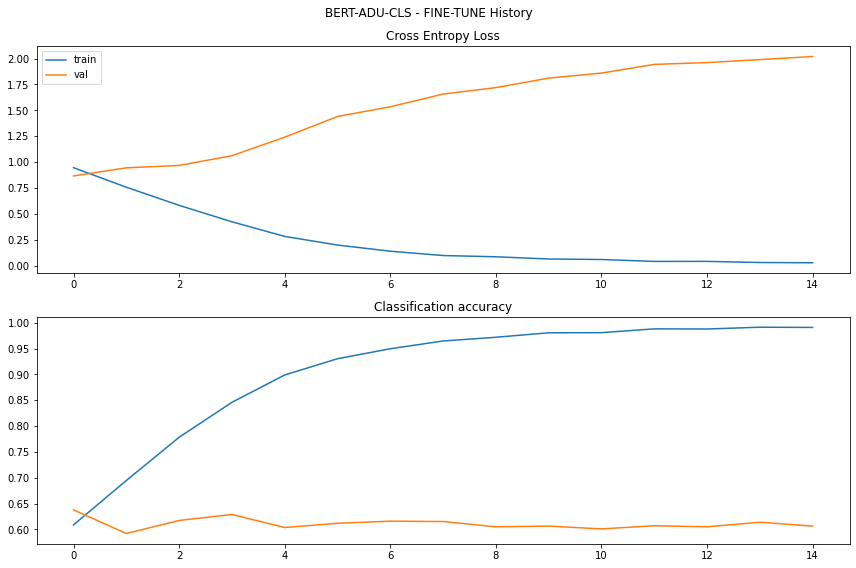

In [41]:
fig = plot_training_history(train_history=ft_train_history, val_history=ft_val_history, model_name="BERT-ADU-CLS", phase_name="FINE-TUNE", out_dir=OUT_DIR)
fig.show()

In [42]:
import gc
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info("cuda:0")

(6420889600, 15843721216)

In [43]:
!nvidia-smi

Wed Jun  8 06:25:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   39C    P0    28W /  70W |   8986MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Test the model

In [44]:
model = AutoModelForSequenceClassification.from_pretrained(f"{OUT_DIR}/fine_tuned/best", num_labels=N_CLASSES)

print("Loaded best fine-tuned model...")

summary(model)

Loaded best fine-tuned model...


Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              30,509,056
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,125
Total params:

In [45]:
accelerator = Accelerator()

model, test_dataloader = accelerator.prepare(model, test_dataloader)

In [46]:
(test_target, test_preds, test_probs, test_ids), test_loss = epoch_iter(
    dataloader=test_dataloader,
    model=model,
    is_train=False,
)

100%|██████████| 1787/1787 [00:42<00:00, 42.06it/s]


In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_target, y_pred=test_preds, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

        Fact       0.64      0.47      0.54       393
      Policy       0.59      0.58      0.58        69
       Value       0.67      0.74      0.70       879
    Value(+)       0.59      0.41      0.49       143
    Value(-)       0.59      0.69      0.63       303

    accuracy                           0.64      1787
   macro avg       0.61      0.58      0.59      1787
weighted avg       0.64      0.64      0.63      1787



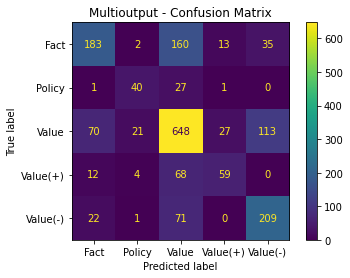

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots()

test_confusion = confusion_matrix(y_true=test_target, y_pred=test_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion, display_labels=le.classes_.tolist())

cm_display.plot(ax=ax)
ax.grid(False)
ax.set_title("Multioutput - Confusion Matrix")
fig.savefig(f"{OUT_DIR}/confusion_matrix.png", dpi=150, bbox_inches='tight')
fig.show()

In [56]:
def getErrors(adu_dataframe, adu_ids, y_true, y_pred):
    df = pd.DataFrame(columns=["id", "adu", "target", "predicted"])
    for (aduId, correct, predicted) in zip(adu_ids, y_true, y_pred):
        if correct == predicted:
            continue
        row = {
            "id": aduId,
            "adu": adu_dataframe.iloc[aduId]["tokens"],
            "target": correct,
            "predicted": predicted
        }
        
        df = df.append(row, ignore_index=True)
    return df

errors_df = getErrors(adus, test_ids, le.inverse_transform(test_target), le.inverse_transform(test_preds))
errors_df

,id,adu,target,predicted
0,15224,ensinar a mentira histórica não é compatível c...,Value,Value(-)
1,45,O problema é que são infinitamente minoritários,Fact,Value
2,15374,"O ano de 2018 foi de crescimento, poder-se-á a...",Value(+),Fact
3,53,"Segundo Galeno (célebre médico grego, tido com...",Fact,Value
4,98,é ao nível económico – concorrência e competit...,Fact,Value
...,...,...,...,...
643,16589,"escreve H.M., “o idioma tem um valor decisivo ...",Fact,Value
644,16662,a escolha da escola e da sua localização tem u...,Fact,Value
645,16689,As restrições orçamentais,Value,Fact
646,16690,"o investimento num curso superior compensa, qu...",Value(+),Value


In [57]:
errors_df.to_csv(f"{OUT_DIR}/test_errors.csv", index=False)

# Compare to other model
Let's also use the other model, that was trained on data which contained conflicted annotations, too see how does it perform here.

In [65]:
import gc
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info("cuda:0")

(3753312256, 15843721216)

In [66]:
!nvidia-smi

Wed Jun  8 06:47:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P0    25W /  70W |  11530MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [67]:
model = AutoModelForSequenceClassification.from_pretrained(f"./out/classification_model/fine_tuned/best", num_labels=N_CLASSES)

print("Loaded best model...")

summary(model)

Loaded best model...


Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              30,509,056
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,125
Total params:

In [68]:
accelerator = Accelerator()

model, test_dataloader = accelerator.prepare(model, test_dataloader)

In [69]:
(test_target, test_preds, test_probs, test_ids), test_loss = epoch_iter(
    dataloader=test_dataloader,
    model=model,
    is_train=False,
)

100%|██████████| 1787/1787 [00:41<00:00, 42.59it/s]


In [70]:
print(classification_report(y_true=test_target, y_pred=test_preds, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

        Fact       0.71      0.48      0.57       393
      Policy       0.68      0.75      0.72        69
       Value       0.69      0.82      0.75       879
    Value(+)       0.77      0.42      0.54       143
    Value(-)       0.69      0.74      0.71       303

    accuracy                           0.70      1787
   macro avg       0.71      0.64      0.66      1787
weighted avg       0.70      0.70      0.69      1787



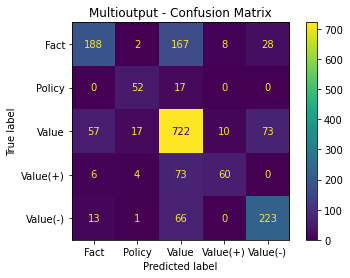

In [71]:
fig, ax = plt.subplots()

test_confusion = confusion_matrix(y_true=test_target, y_pred=test_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion, display_labels=le.classes_.tolist())

cm_display.plot(ax=ax)
ax.grid(False)
ax.set_title("Multioutput - Confusion Matrix")
fig.savefig(f"{OUT_DIR}/cls_conflict_confusion_matrix.png", dpi=150, bbox_inches='tight')
fig.show()

In [72]:
def getErrors(adu_dataframe, adu_ids, y_true, y_pred):
    df = pd.DataFrame(columns=["id", "adu", "target", "predicted"])
    for (aduId, correct, predicted) in zip(adu_ids, y_true, y_pred):
        if correct == predicted:
            continue
        row = {
            "id": aduId,
            "adu": adu_dataframe.iloc[aduId]["tokens"],
            "target": correct,
            "predicted": predicted
        }
        
        df = df.append(row, ignore_index=True)
    return df

errors_df = getErrors(adus, test_ids, le.inverse_transform(test_target), le.inverse_transform(test_preds))
errors_df

,id,adu,target,predicted
0,15350,Esses três pilares são fundamentais para o ava...,Value(+),Value
1,45,O problema é que são infinitamente minoritários,Fact,Value
2,53,"Segundo Galeno (célebre médico grego, tido com...",Fact,Value
3,98,é ao nível económico – concorrência e competit...,Fact,Value
4,15704,"no caso da Guiné-Bissau, podemos afirmar categ...",Value(-),Value
...,...,...,...,...
537,16589,"escreve H.M., “o idioma tem um valor decisivo ...",Fact,Value
538,16662,a escolha da escola e da sua localização tem u...,Fact,Value
539,16689,As restrições orçamentais,Value,Fact
540,16690,"o investimento num curso superior compensa, qu...",Value(+),Value


In [73]:
errors_df.to_csv(f"{OUT_DIR}/cls_conflict_test_errors.csv", index=False)

# Fine-tune other model using non-conflicted dataset

In [33]:
import gc
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info("cuda:0")

(13322616832, 15843721216)

In [34]:
!nvidia-smi

Wed Jun  8 09:57:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |   2404MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [35]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

BATCH_SIZE = 64 # Tested with NVIDIA Tesla T4 16GB

train_dataloader = DataLoader(
    dataset=cls_dataset["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    dataset=cls_dataset["val"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(f"./out/classification_model/fine_tuned/best", num_labels=N_CLASSES)

print("Loaded best model...")

summary(model)

Loaded best model...


Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              30,509,056
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,125
Total params:

In [37]:
ft_optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-4,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

accelerator = Accelerator()

model, ft_optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, ft_optimizer, train_dataloader, val_dataloader
)

In [38]:
ft_train_history = {
    "loss": [],
    "accuracy": []
}

ft_val_history = {
    "loss": [],
    "accuracy": []
}

FT_NUM_EPOCHS = 10
model.bert.requires_grad_(False) # Freeze language model layer, not worth leaving it unfrozen

ft_best_loss = np.inf
ft_best_accuracy = 0
ft_best_epoch = -1

print(f"Starting classification language model fine-tuning...")

for epoch in range(1, FT_NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{FT_NUM_EPOCHS}]")
    
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        is_train=True,
        optimizer=ft_optimizer,
        lr_scheduler=None
    )
    
    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")
    
    # Save best model
    if val_loss < ft_best_loss:
        ft_best_loss = val_loss
        ft_best_accuracy = val_accuracy
        ft_best_epoch = epoch
        
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(f"{OUT_DIR}/fine_tuned2/best", save_function=accelerator.save)

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(f"{OUT_DIR}/fine_tuned2/latest", save_function=accelerator.save)

    ft_train_history["loss"].append(train_loss)
    ft_train_history["accuracy"].append(train_accuracy)

    ft_val_history["loss"].append(val_loss)
    ft_val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")
    
print(
    f"\nFinished fine-tuning..."
    f"\nBest epoch: {ft_best_epoch}\t Validation loss on best epoch: {ft_best_loss}\t Accuracy on best epoch: {ft_best_accuracy}"
)

Starting classification language model fine-tuning...
Epoch[1/10]


100%|██████████| 109/109 [00:37<00:00,  2.89it/s]


Training loss: 0.799	 Training micro accuracy: 0.682


100%|██████████| 23/23 [00:06<00:00,  3.46it/s]


Validation loss: 0.725	 Validation micro accuracy: 0.705
----------------------------------------------------------------
Epoch[2/10]


100%|██████████| 109/109 [00:38<00:00,  2.85it/s]


Training loss: 0.795	 Training micro accuracy: 0.681


100%|██████████| 23/23 [00:06<00:00,  3.35it/s]


Validation loss: 0.725	 Validation micro accuracy: 0.711
----------------------------------------------------------------
Epoch[3/10]


100%|██████████| 109/109 [00:37<00:00,  2.88it/s]


Training loss: 0.790	 Training micro accuracy: 0.683


100%|██████████| 23/23 [00:07<00:00,  3.28it/s]


Validation loss: 0.720	 Validation micro accuracy: 0.703
----------------------------------------------------------------
Epoch[4/10]


100%|██████████| 109/109 [00:39<00:00,  2.77it/s]


Training loss: 0.793	 Training micro accuracy: 0.684


100%|██████████| 23/23 [00:07<00:00,  3.25it/s]


Validation loss: 0.719	 Validation micro accuracy: 0.701
----------------------------------------------------------------
Epoch[5/10]


100%|██████████| 109/109 [00:39<00:00,  2.77it/s]


Training loss: 0.782	 Training micro accuracy: 0.690


100%|██████████| 23/23 [00:07<00:00,  3.24it/s]


Validation loss: 0.719	 Validation micro accuracy: 0.705
----------------------------------------------------------------
Epoch[6/10]


100%|██████████| 109/109 [00:39<00:00,  2.75it/s]


Training loss: 0.790	 Training micro accuracy: 0.682


100%|██████████| 23/23 [00:07<00:00,  3.23it/s]


Validation loss: 0.718	 Validation micro accuracy: 0.702
----------------------------------------------------------------
Epoch[7/10]


100%|██████████| 109/109 [00:40<00:00,  2.72it/s]


Training loss: 0.789	 Training micro accuracy: 0.689


100%|██████████| 23/23 [00:07<00:00,  3.23it/s]


Validation loss: 0.717	 Validation micro accuracy: 0.707
----------------------------------------------------------------
Epoch[8/10]


100%|██████████| 109/109 [00:38<00:00,  2.80it/s]


Training loss: 0.782	 Training micro accuracy: 0.686


100%|██████████| 23/23 [00:07<00:00,  3.24it/s]


Validation loss: 0.716	 Validation micro accuracy: 0.703
----------------------------------------------------------------
Epoch[9/10]


100%|██████████| 109/109 [00:39<00:00,  2.78it/s]


Training loss: 0.786	 Training micro accuracy: 0.679


100%|██████████| 23/23 [00:07<00:00,  3.25it/s]


Validation loss: 0.718	 Validation micro accuracy: 0.705
----------------------------------------------------------------
Epoch[10/10]


100%|██████████| 109/109 [00:39<00:00,  2.74it/s]


Training loss: 0.780	 Training micro accuracy: 0.685


100%|██████████| 23/23 [00:07<00:00,  3.23it/s]


Validation loss: 0.715	 Validation micro accuracy: 0.705
----------------------------------------------------------------

Finished fine-tuning...
Best epoch: 10	 Validation loss on best epoch: 0.7152820592341216	 Accuracy on best epoch: 0.7045609354972839


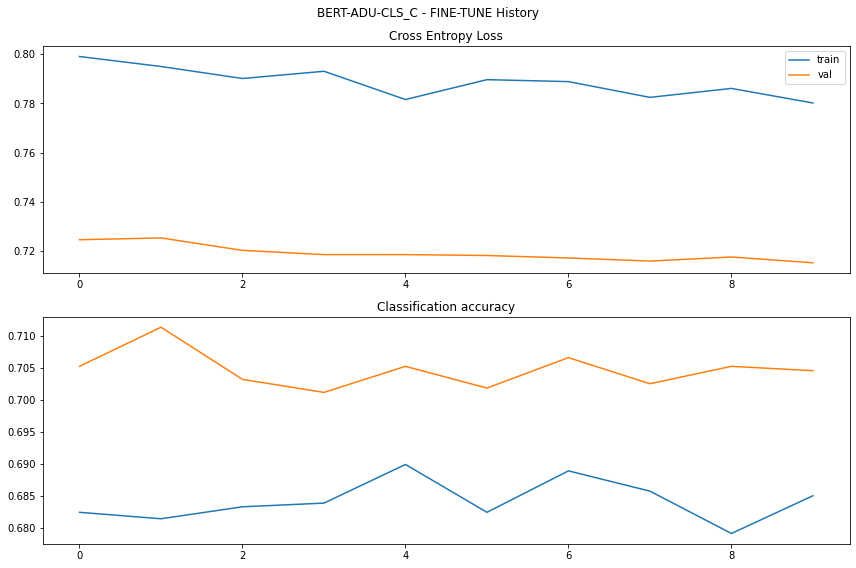

In [49]:
fig = plot_training_history(train_history=ft_train_history, val_history=ft_val_history, model_name="BERT-ADU-CLS_C", phase_name="FINE-TUNE", out_dir=OUT_DIR)
fig.show()

# Test the fine-tuned model

In [39]:
import gc
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info("cuda:0")

(11969953792, 15843721216)

In [40]:
!nvidia-smi

Wed Jun  8 10:06:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |   3694MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [41]:
model = AutoModelForSequenceClassification.from_pretrained(f"{OUT_DIR}/fine_tuned2/best", num_labels=N_CLASSES)

print("Loaded best model...")

summary(model)

Loaded best model...


Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              30,509,056
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,125
Total params:

In [42]:
accelerator = Accelerator()

model, test_dataloader = accelerator.prepare(model, test_dataloader)

In [43]:
(test_target, test_preds, test_probs, test_ids), test_loss = epoch_iter(
    dataloader=test_dataloader,
    model=model,
    is_train=False,
)

100%|██████████| 1787/1787 [00:38<00:00, 46.63it/s]


In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_target, y_pred=test_preds, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

        Fact       0.70      0.52      0.60       393
      Policy       0.65      0.78      0.71        69
       Value       0.71      0.82      0.76       879
    Value(+)       0.74      0.51      0.61       143
    Value(-)       0.71      0.71      0.71       303

    accuracy                           0.71      1787
   macro avg       0.70      0.67      0.68      1787
weighted avg       0.71      0.71      0.70      1787



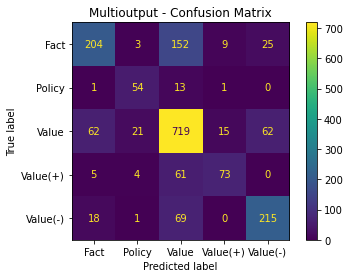

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots()

test_confusion = confusion_matrix(y_true=test_target, y_pred=test_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion, display_labels=le.classes_.tolist())

cm_display.plot(ax=ax)
ax.grid(False)
ax.set_title("Multioutput - Confusion Matrix")
fig.savefig(f"{OUT_DIR}/cls_conflict_fine_tuned_confusion_matrix.png", dpi=150, bbox_inches='tight')
fig.show()

In [47]:
def getErrors(adu_dataframe, adu_ids, y_true, y_pred):
    df = pd.DataFrame(columns=["id", "adu", "target", "predicted"])
    for (aduId, correct, predicted) in zip(adu_ids, y_true, y_pred):
        if correct == predicted:
            continue
        row = {
            "id": aduId,
            "adu": adu_dataframe.iloc[aduId]["tokens"],
            "target": correct,
            "predicted": predicted
        }
        
        df = df.append(row, ignore_index=True)
    return df

errors_df = getErrors(adus, test_ids, le.inverse_transform(test_target), le.inverse_transform(test_preds))
errors_df

,id,adu,target,predicted
0,45,O problema é que são infinitamente minoritários,Fact,Value
1,53,"Segundo Galeno (célebre médico grego, tido com...",Fact,Value
2,98,é ao nível económico – concorrência e competit...,Fact,Value
3,15704,"no caso da Guiné-Bissau, podemos afirmar categ...",Value(-),Value
4,179,informar as pessoas do que podemos oferecer,Fact,Value
...,...,...,...,...
517,16589,"escreve H.M., “o idioma tem um valor decisivo ...",Fact,Value
518,16662,a escolha da escola e da sua localização tem u...,Fact,Value
519,16689,As restrições orçamentais,Value,Fact
520,16690,"o investimento num curso superior compensa, qu...",Value(+),Value


In [48]:
errors_df.to_csv(f"{OUT_DIR}/cls_conflict_fine_tuned_test_errors.csv", index=False)